In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import datetime
import time
import logging

from sklearn.metrics import mean_squared_error 
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

from IPython.core.debugger import set_trace

import random

# import xgboost
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import os

from tqdm import *

import sys
sys.path.insert(0, '../')

import scipy.sparse as sp
# tells which GPU to use.

import torch
from torch.utils.data import Dataset, DataLoader
# Reproducibility...
seed = 1017
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from egexplainer import AttributionPriorExplainer
torch.set_num_threads(1)

In [2]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [3]:
# Code to generate hubness feature
"""
df = pd.read_csv("./brain_top", sep="\t")
df.columns = ["Gene 1", "Gene 2", "Posterior Prob."]

from tqdm import tqdm_notebook

tqdm.pandas()
df_summed = df.drop("Gene 2", axis=1).groupby("Gene 1").sum().reset_index()

import mygene
mg = mygene.MyGeneInfo()

def entrez_to_symbol(entrez_id):
    gene_info = mg.getgene(entrez_id)
    return gene_info['symbol'] if gene_info else None

df_summed["Gene 1"] = df_summed["Gene 1"].progress_map(lambda x: entrez_to_symbol(x))
"""

'\ndf = pd.read_csv("./brain_top", sep="\t")\ndf.columns = ["Gene 1", "Gene 2", "Posterior Prob."]\n\nfrom tqdm import tqdm_notebook\n\ntqdm.pandas()\ndf_summed = df.drop("Gene 2", axis=1).groupby("Gene 1").sum().reset_index()\n\nimport mygene\nmg = mygene.MyGeneInfo()\n\ndef entrez_to_symbol(entrez_id):\n    gene_info = mg.getgene(entrez_id)\n    return gene_info[\'symbol\'] if gene_info else None\n\ndf_summed["Gene 1"] = df_summed["Gene 1"].progress_map(lambda x: entrez_to_symbol(x))\n'

In [4]:
"""
import GEOparse
gse = GEOparse.get_GEO(geo="GSE80970", destdir="./")
methylation_illumina = pd.read_csv("HumanMethylation450_15017482_v1-2.csv")
methylation_illumina = methylation_illumina[["IlmnID", "UCSC_RefGene_Name"]]
methylation_illumina = methylation_illumina.dropna()
methylation_illumina = methylation_illumina.set_index("IlmnID")
methylation_values = None
methylation_regions = None
for gsm_name, gsm in gse.gsms.items():
    if methylation_values is not None:
        methylation_values += gsm.table["VALUE"]
    else:
        methylation_values = gsm.table["VALUE"]
        methylation_regions = gsm.table["ID_REF"]
methylation_values /= len(gse.gsms.items())

methylation_df = pd.DataFrame(data={
    "ID_REF": methylation_regions,
    "Methylation": methylation_values
}).set_index("ID_REF")
methylation_df = methylation_df.loc[methylation_illumina.index]
methylation_df["UCSC_RefGene_Name"] = methylation_illumina["UCSC_RefGene_Name"].map(lambda x: x.split(";")[0])
methylation_df = methylation_df.dropna()
methylation_df = methylation_df.groupby("UCSC_RefGene_Name").mean()
methylation_df = methylation_df.T
"""

'\nimport GEOparse\ngse = GEOparse.get_GEO(geo="GSE80970", destdir="./")\nmethylation_illumina = pd.read_csv("HumanMethylation450_15017482_v1-2.csv")\nmethylation_illumina = methylation_illumina[["IlmnID", "UCSC_RefGene_Name"]]\nmethylation_illumina = methylation_illumina.dropna()\nmethylation_illumina = methylation_illumina.set_index("IlmnID")\nmethylation_values = None\nmethylation_regions = None\nfor gsm_name, gsm in gse.gsms.items():\n    if methylation_values is not None:\n        methylation_values += gsm.table["VALUE"]\n    else:\n        methylation_values = gsm.table["VALUE"]\n        methylation_regions = gsm.table["ID_REF"]\nmethylation_values /= len(gse.gsms.items())\n\nmethylation_df = pd.DataFrame(data={\n    "ID_REF": methylation_regions,\n    "Methylation": methylation_values\n}).set_index("ID_REF")\nmethylation_df = methylation_df.loc[methylation_illumina.index]\nmethylation_df["UCSC_RefGene_Name"] = methylation_illumina["UCSC_RefGene_Name"].map(lambda x: x.split(";")[

In [5]:
"""
ad_hubness = pickle.load(open("ad_hubness.p", "rb"))
ad_hubness.dropna(inplace=True)
ad_hubness = ad_hubness.groupby("Gene 1").mean()
ad_hubness = ad_hubness.rename(columns={"Posterior Prob.": "Hubness"})
ad_hubness = ad_hubness.T
"""

'\nad_hubness = pickle.load(open("ad_hubness.p", "rb"))\nad_hubness.dropna(inplace=True)\nad_hubness = ad_hubness.groupby("Gene 1").mean()\nad_hubness = ad_hubness.rename(columns={"Posterior Prob.": "Hubness"})\nad_hubness = ad_hubness.T\n'

In [6]:
#from data import MergeData
#merge_data = MergeData.load_data()

In [7]:
#regulator = pd.DataFrame(merge_data.data.T["Regulator"]).T

In [8]:
#cnv = pd.DataFrame(merge_data.data.T["Genomic abnormalities (CNV)"]).T

In [9]:
#overlapping_genes = set(methylation_df.columns).intersection(ad_hubness.columns).intersection(cnv.columns).intersection(regulator.columns)

In [10]:
#ad_hubness = ad_hubness[overlapping_genes]
#methylation_df = methylation_df[overlapping_genes]
#cnv = cnv[overlapping_genes]
#

# pre-process abeta data

In [11]:
data_dir = "/projects/leelab2/jjanizek/"

##
## put everything in 0-1 by region
##

#Read all region expressions
regions = ['ACT_FWM', 'ACT_HIP', 'ACT_PCx', 'ACT_TCx', 'MSBB_BM10', 'MSBB_BM22', 'MSBB_BM36', 'MSBB_BM44', 'ROSMAP' ]

data_list = []

for region in regions:
    
    #Read expression
    data_df = pd.read_table(data_dir + 'AD_DATA/abeta_' + region + '.csv', index_col = 0, sep = ',')
    
    data_df.columns = ['abeta']
    
    standardized_df = (data_df - data_df.min())/(data_df.max()- data_df.min())

    #Append to list
    data_list.append(standardized_df)
    
    #Join all data
joined_df = pd.concat(data_list, axis = 0)

In [12]:
y = joined_df

In [13]:
X = pd.read_csv(data_dir + 'AD_DATA/AD_DATA/AD_RnaSeq_Expression_Standardized_Batch_Corrected.tsv',sep='\t',index_col=0)

/homes/gws/ewein/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
prior_info = pd.read_csv("./cram.csv")
overlapping_genes = list(set(X.columns).intersection(prior_info.columns))
X = X[overlapping_genes]
prior_info = prior_info[overlapping_genes]
prior_info = prior_info.T
prior_info = torch.FloatTensor(prior_info.values).cuda()

In [15]:
#Split the data to training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1017)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1017)

In [16]:
feature_scaler = StandardScaler()
outcome_scaler = StandardScaler()

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)

feature_scaler.fit(X_train)
outcome_scaler.fit(y_train)

X_train_ss, X_val_ss, X_test_ss = feature_scaler.transform(X_train), feature_scaler.transform(X_val), feature_scaler.transform(X_test)
y_train_ss, y_val_ss, y_test_ss = outcome_scaler.transform(y_train), outcome_scaler.transform(y_val), outcome_scaler.transform(y_test)

In [17]:
class ADData(Dataset):
    
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        sample = self.X[index,:]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        if self.y is not None:
            return sample, self.y[index]
        else:
            return sample

In [18]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N = 32

# Create random Tensors to hold inputs and outputs
train_dataset = ADData(X_train_ss,y_train_ss)
val_dataset = ADData(X_val_ss, y_val_ss)
test_dataset = ADData(X_test_ss,y_test_ss)

train_loader = DataLoader(dataset=train_dataset, batch_size=N)
valid_loader = DataLoader(dataset=val_dataset, batch_size=N)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_dataset.X.shape[0])

In [19]:
learning_rate = 1e-4
prior_learning_rate = 1e-5

In [20]:
from models import MLP
from utils import train
from torch.nn import MSELoss
from utils import EarlyStopping
patience = 100

D_in, H1, H2, D_out = X_train.shape[1], 512, 256, 1
f1 = MLP(D_in=D_in, H1=H1, H2=H2, D_out=D_out, dropout=0.0).cuda().float()
f1_optimizer = torch.optim.Adam(f1.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

losses_no_prior = []

def train(model, optimizer):
    print("Beginning model training at {}".format(datetime.datetime.now()))
    early_stopping = EarlyStopping(patience=patience)
    epoch = 0
    while True:
        start_time = time.time()
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()

            output = model(X_batch)
            loss_train = criterion(output, y_batch)

            loss_train.backward()
            optimizer.step()

        model.eval()
        for X_batch, y_batch in valid_loader:
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()

            output = model(X_batch)
            loss_valid = criterion(output, y_batch).item()
            end_time = time.time()
            epoch_time = end_time - start_time

        if epoch % 10 == 0:
            logging.info("Epoch {} completed in {} secs with valid loss {:.4f}".format(epoch, epoch_time, loss_valid))

        early_stopping(loss_valid, model)

        if early_stopping.early_stop:
            print("Early stopping on epoch {}".format(epoch))
            print("Final valid loss {}".format(early_stopping.val_metric_min))
            break
        epoch += 1
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.float().cuda()
        y_batch = y_batch.float().cuda()

        output = model(X_batch)
        loss_test = criterion(output, y_batch).item()
    return loss_test

print(train(f1, f1_optimizer))


Beginning model training at 2019-12-26 18:12:06.484696


2019-12-26 18:12:06 INFO     Epoch 0 completed in 0.2299959659576416 secs with valid loss 2.1864
2019-12-26 18:12:09 INFO     Epoch 10 completed in 0.21743988990783691 secs with valid loss 1.6532
2019-12-26 18:12:12 INFO     Epoch 20 completed in 0.21082639694213867 secs with valid loss 1.8457
2019-12-26 18:12:14 INFO     Epoch 30 completed in 0.21333813667297363 secs with valid loss 2.2449
2019-12-26 18:12:16 INFO     Epoch 40 completed in 0.19721508026123047 secs with valid loss 2.1752
2019-12-26 18:12:18 INFO     Epoch 50 completed in 0.19692158699035645 secs with valid loss 1.9388
2019-12-26 18:12:20 INFO     Epoch 60 completed in 0.19557929039001465 secs with valid loss 1.9357
2019-12-26 18:12:22 INFO     Epoch 70 completed in 0.19836783409118652 secs with valid loss 2.0995
2019-12-26 18:12:24 INFO     Epoch 80 completed in 0.21590423583984375 secs with valid loss 2.1930
2019-12-26 18:12:26 INFO     Epoch 90 completed in 0.21646475791931152 secs with valid loss 1.9521
2019-12-26 1

Early stopping on epoch 107
Final valid loss 1.6004401445388794
0.8677023649215698


In [21]:
import egexplainer
import importlib

importlib.reload(egexplainer)

APExp = egexplainer.VariableBatchExplainer(train_dataset)

In [22]:
def train_with_learned_prior(f1, f2, f1_optimizer, f2_optimizer, prior_info):
    print("Beginning model training at {}".format(datetime.datetime.now()))
    early_stopping = EarlyStopping(patience=patience)
    epoch = 0
    while True:
        start_time = time.time()
        f1.train()
        for X_batch, y_batch in train_loader:
            f1_optimizer.zero_grad()
            f2_optimizer.zero_grad()

            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()

            output = f1(X_batch)

            eg = APExp.shap_values(f1, X_batch).abs()
            prior_differences = f2(prior_info).squeeze()
            prior_loss = ((prior_differences - eg) ** 2).mean()

            loss_train = criterion(output, y_batch) + prior_loss

            loss_train.backward()
            f1_optimizer.step()
            f2_optimizer.step()

        f1.eval()
        for X_batch, y_batch in valid_loader:
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()

            output = f1(X_batch)
            loss_valid = criterion(output, y_batch).item()
            end_time = time.time()
            epoch_time = end_time - start_time

        if epoch % 10 == 0:
            logging.info("Epoch {} completed in {} secs with valid loss {:.4f}".format(epoch, epoch_time, loss_valid))

        early_stopping(loss_valid, [f1, f2])

        if early_stopping.early_stop:
            print("Early stopping on epoch {}".format(epoch))
            print("Final valid loss {}".format(loss_valid))
            break
        epoch += 1
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.float().cuda()
        y_batch = y_batch.float().cuda()

        output = f1(X_batch)
        loss_test = criterion(output, y_batch).item()
    return loss_test

In [23]:
from models import LinearModel, ShallowMLP

D_in, H1, H2, D_out = X_train.shape[1], 512, 256, 1

f1 = MLP(D_in=D_in, H1=H1, H2=H2, D_out=D_out, dropout=0.5).cuda().float()
f1_optimizer = torch.optim.Adam(f1.parameters(), lr=learning_rate)

f2 = ShallowMLP(
    D_in = prior_info.shape[1],
    H1 = 2,
    D_out = 1,
    dropout = 0.0
).cuda().float()

"""
f2 = LinearModel(
    D_in = prior_info.shape[1],
    D_out = 1
).cuda()
"""
f2_optimizer = torch.optim.Adam(f2.parameters(), lr=prior_learning_rate)
train_with_learned_prior(f1, f2, f1_optimizer, f2_optimizer, prior_info)

Beginning model training at 2019-12-26 18:12:30.296947


2019-12-26 18:12:30 INFO     Epoch 0 completed in 0.5941436290740967 secs with valid loss 2.2278
2019-12-26 18:12:37 INFO     Epoch 10 completed in 0.5473823547363281 secs with valid loss 2.1033
2019-12-26 18:12:43 INFO     Epoch 20 completed in 0.6167576313018799 secs with valid loss 2.0510
2019-12-26 18:12:48 INFO     Epoch 30 completed in 0.5546169281005859 secs with valid loss 1.9148
2019-12-26 18:12:54 INFO     Epoch 40 completed in 0.5955965518951416 secs with valid loss 2.0088
2019-12-26 18:12:59 INFO     Epoch 50 completed in 0.5515739917755127 secs with valid loss 2.1729
2019-12-26 18:13:05 INFO     Epoch 60 completed in 0.5513410568237305 secs with valid loss 2.0592
2019-12-26 18:13:11 INFO     Epoch 70 completed in 0.5580673217773438 secs with valid loss 2.0690
2019-12-26 18:13:16 INFO     Epoch 80 completed in 0.5799283981323242 secs with valid loss 2.0405
2019-12-26 18:13:22 INFO     Epoch 90 completed in 0.5483818054199219 secs with valid loss 2.0710
2019-12-26 18:13:28 I

Early stopping on epoch 116
Final valid loss 2.067944288253784


0.8202336430549622

In [24]:
from data import BasicDataset

prior_data = BasicDataset(X = prior_info, y = np.zeros(prior_info.shape[0]))

meta_APExp = egexplainer.VariableBatchExplainer(prior_data)

In [25]:
for X_batch, y_batch in test_loader:
    y_batch = y_batch.squeeze()
    X_batch = X_batch.float().cuda()
    y_batch = y_batch.float().cuda()
    predicted_attributions = f2(prior_info).abs().squeeze().cpu().detach().numpy()
    meta_eg = meta_APExp.shap_values(f2, prior_info).abs().cpu().detach().numpy()

In [26]:
meta_eg = np.abs(meta_eg)
row_sums = meta_eg.sum(axis=1)
meta_eg = meta_eg / row_sums[:, np.newaxis]
meta_eg = (meta_eg.T * predicted_attributions).T

/homes/gws/ewein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
df = pd.DataFrame(data={
    "Connectivity": meta_eg[:,0],
    "Methylation": meta_eg[:,1],
    "CNV": meta_eg[:,2],
    "Regulator": meta_eg[:,3],
    "total_attribution": predicted_attributions
},
index=overlapping_genes)

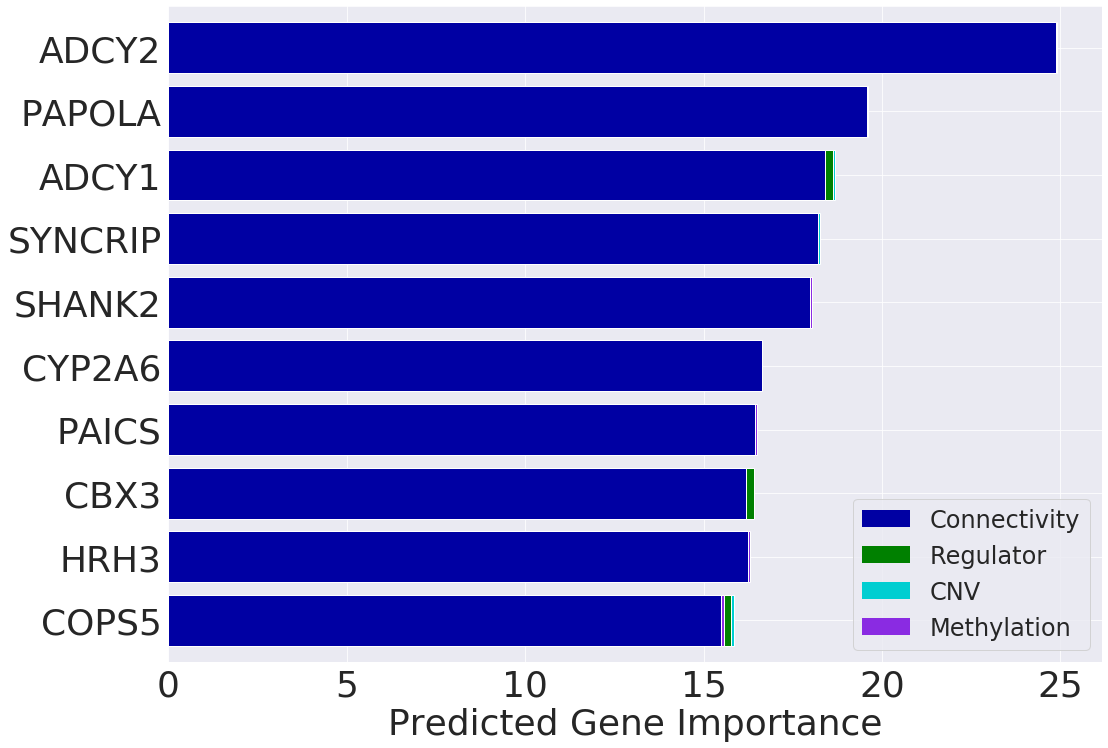

In [28]:
num_bars = 10
data_to_plot = df.dropna().nlargest(num_bars, "total_attribution")

data_to_plot = data_to_plot.sort_values(by="total_attribution", ascending=True)
data_to_plot.drop("total_attribution", axis=1, inplace=True)

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context({"figure.figsize": (24, 10)})

colors = {
    "connectivity": "#0000A3",
    "methylation": "#8A2BE2",
    "regulator": "#008000",
    "cnv": "#00CED1"
}

connectivity_bar = plt.Rectangle((0,0),1,1,fc=colors["connectivity"],  edgecolor = 'none')
methylation_bar = plt.Rectangle((0,0),1,1,fc=colors["methylation"],edgecolor = 'none')
regulator_bar = plt.Rectangle((0,0),1,1,fc=colors["regulator"],  edgecolor = 'none')
cnv_bar = plt.Rectangle((0,0),1,1,fc=colors["cnv"], edgecolor = 'none')

data_to_plot.plot(
    kind="barh",
    stacked=True,
    color=[
        colors["connectivity"],
        colors["methylation"],
        colors["regulator"],
        colors["cnv"]
    ],
    figsize=(48,24),
    width=0.8,
    legend=None
)

plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
plt.ylabel("")

plt.legend(
    [connectivity_bar, regulator_bar, cnv_bar, methylation_bar],
    ['Connectivity', "Regulator", "CNV", "Methylation"],
    ncol = 1,
    prop={'size':24}
)

plt.xlabel("Predicted Gene Importance", fontsize=36)

fig = plt.gcf()
fig.set_size_inches(15.5, 10.5)
plt.tight_layout()